In [223]:
import math
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from keras.layers import Input, Dense, Dropout, Flatten, Embedding, merge, BatchNormalization, GaussianNoise
from keras.regularizers import l2
from keras.layers import deserialize as layer_from_config
from keras.optimizers import Adam
from keras.models import Model

import tensorflow as tf

## Read Input Data

In [120]:
data_dir = '../../input/'
xTrain = np.load(data_dir + 'FeatureMatrix/xTrain.npy')
yTrain = np.load(data_dir + 'FeatureMatrix/yTrain.npy')
xTest = np.load(data_dir + 'FeatureMatrix/xTest2015.npy')
yTest = np.load(data_dir + 'FeatureMatrix/yTest2015.npy')

In [29]:
xTrain.shape

(98827, 17)

In [30]:
yTrain.shape

(98827,)

Feature No. 0
Unique Values: 60


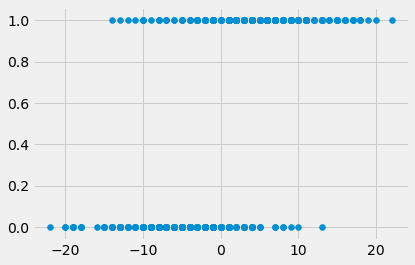

Feature No. 1
Unique Values: 68794


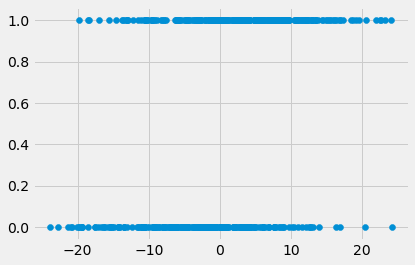

Feature No. 2
Unique Values: 67280


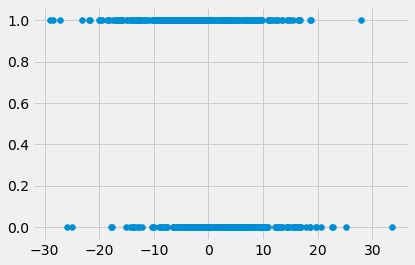

Feature No. 3
Unique Values: 3


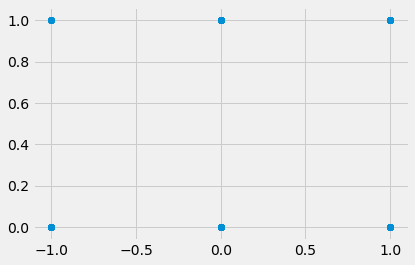

Feature No. 4
Unique Values: 53227


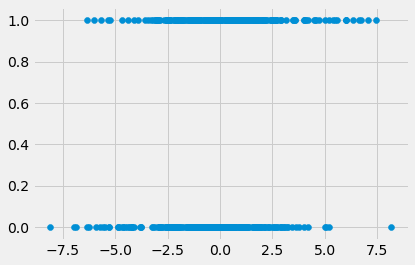

Feature No. 5
Unique Values: 58959


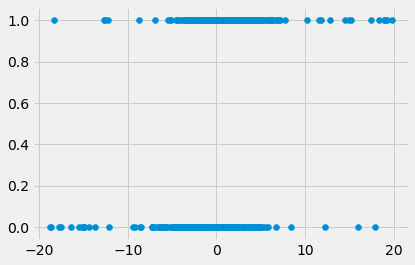

Feature No. 6
Unique Values: 37739


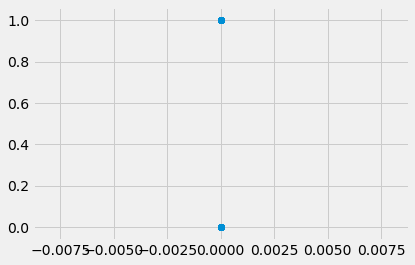

Feature No. 7
Unique Values: 3


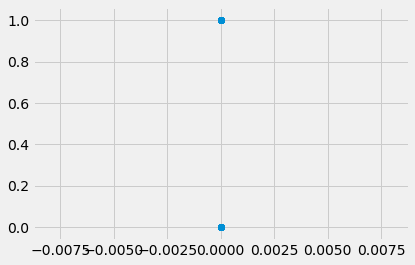

Feature No. 8
Unique Values: 3


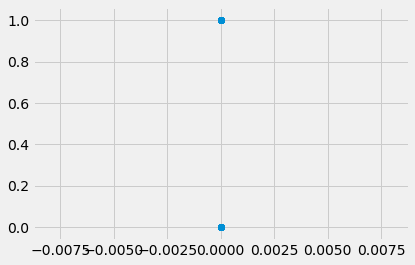

Feature No. 9
Unique Values: 49


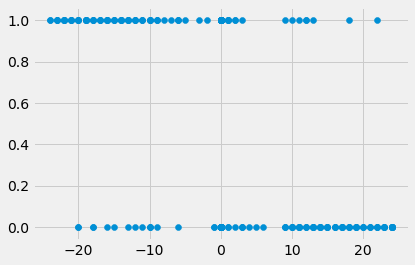

Feature No. 10
Unique Values: 9148


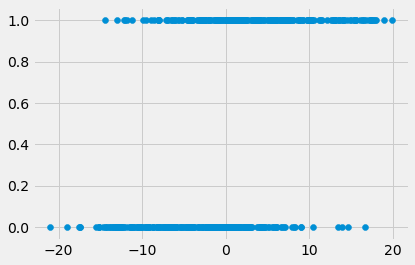

Feature No. 11
Unique Values: 15037


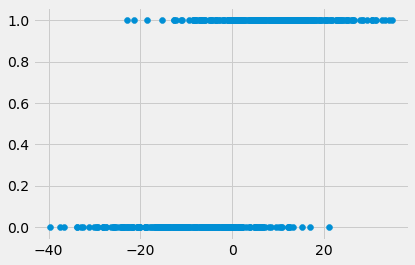

Feature No. 12
Unique Values: 58849


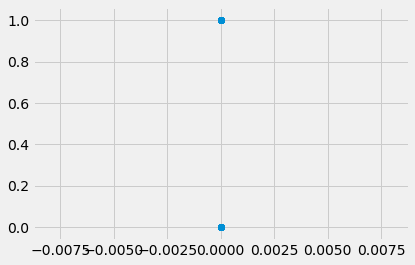

Feature No. 13
Unique Values: 55837


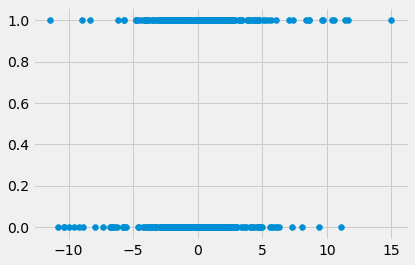

Feature No. 14
Unique Values: 65


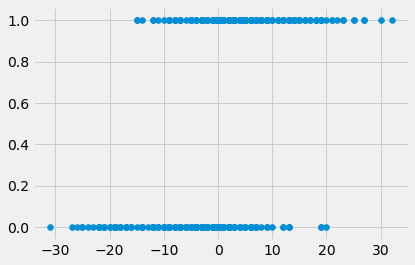

Feature No. 15
Unique Values: 11


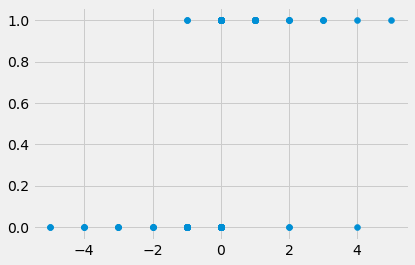

Feature No. 16
Unique Values: 3


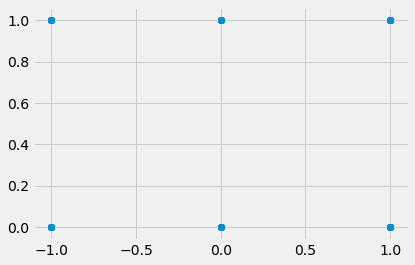

Continuous Feats: [0, 1, 2, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15]
Discrete Feats: [3, 7, 8, 16]


In [209]:
feats1 = []
feats2 = []
for i in range(17):
    print('Feature No.', i)
    print('Unique Values:', len(np.unique(xTrain[:,i])))
    if len(np.unique(xTrain[:,i])) > 10:
        feats1.append(i)
    else:
        feats2.append(i)
    plt.scatter(xTrain[:,i][:500], yTrain[:500])
    plt.show()
print('Continuous Feats:', feats1)
print('Discrete Feats:', feats2)

In [195]:
xTest.shape

(5421, 17)

In [196]:
yTest.shape

(5421,)

## Params

In [197]:
num_features = 17
test_year = 2015

learning_rate = 0.01
training_epochs = 25
batch_size = 100
display_step = 1

## Build Model

In [210]:
xFeat1 = xTrain[:,feats1]
xFeat2 = xTrain[:,feats2]
print(xTrain.shape)
print(xFeat1.shape)
print(xFeat2.shape)

(98827, 17)
(98827, 13)
(98827, 4)


In [229]:
model = Sequential([
    Dropout(0.1, input_shape=(xTrain.shape[1],)),

    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=0, weights=None, beta_initializer='zeros', gamma_initializer='ones', gamma_regularizer=None, beta_regularizer=None),
    GaussianNoise(0.01),
    Dense(256, kernel_regularizer=l2(0.01), activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='softmax'),
])
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [227]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_10 (Dropout)         (None, 17)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 17)                51        
_________________________________________________________________
gaussian_noise_8 (GaussianNo (None, 17)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               4608      
_________________________________________________________________
dense_34 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_35 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_36 (Dense)             (None, 32)                1056      
__________

In [ ]:
history = model.fit(xTrain, yTrain, batch_size=100, epochs=10, verbose=2)

Epoch 1/10


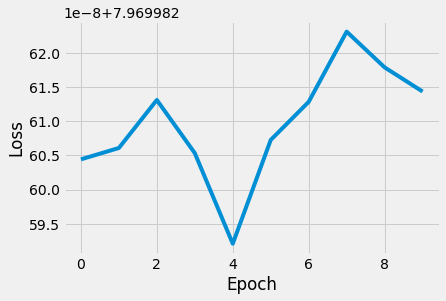

In [88]:
plt.plot(history.history["loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [92]:
from sklearn import linear_model

In [93]:
model = linear_model.LogisticRegression()
def sample_train():
    model.fit(xTrain, yTrain)
sample_train()

## Create Season Data

### Read Data

In [159]:
data_dir = '../../input/'
kaggle_data_dir = data_dir + 'KaggleData/'
MM_stats_data_dir = data_dir + 'MMStats/'

reg_season_compact_pd = pd.read_csv(kaggle_data_dir + 'RegularSeasonCompactResults.csv')
reg_season_detailed_pd = pd.read_csv(kaggle_data_dir + 'RegularSeasonDetailedResults.csv')
seasons_pd = pd.read_csv(kaggle_data_dir + 'Seasons.csv')
teams_pd = pd.read_csv(kaggle_data_dir + 'Teams.csv')
teamList = teams_pd['TeamName'].tolist()
tourney_compact_pd = pd.read_csv(kaggle_data_dir + 'NCAATourneyCompactResults.csv')
tourney_detailed_pd = pd.read_csv(kaggle_data_dir + 'NCAATourneyDetailedResults.csv')
tourney_seeds_pd = pd.read_csv(kaggle_data_dir + 'NCAATourneySeeds.csv')
duke_id = teams_pd[teams_pd['TeamName'] == 'Duke'].values[0][0]
conference_pd = pd.read_csv(kaggle_data_dir + 'Conference.csv')
tourney_results_pd = pd.read_csv(kaggle_data_dir + 'TourneyResults.csv')
tourney_results_pd.head()
NCAAChampionsList = tourney_results_pd['NCAA Champion'].tolist()

In [160]:
listACCteams = ['North Carolina','Virginia','Florida St','Louisville','Notre Dame','Syracuse','Duke','Virginia Tech','Georgia Tech','Miami','Wake Forest','Clemson','NC State','Boston College','Pittsburgh']
listPac12teams = ['Arizona','Oregon','UCLA','California','USC','Utah','Washington St','Stanford','Arizona St','Colorado','Washington','Oregon St']
listSECteams = ['Kentucky','South Carolina','Florida','Arkansas','Alabama','Tennessee','Mississippi St','Georgia','Ole Miss','Vanderbilt','Auburn','Texas A&M','LSU','Missouri']
listBig10teams = ['Maryland','Wisconsin','Purdue','Northwestern','Michigan St','Indiana','Iowa','Michigan','Penn St','Nebraska','Minnesota','Illinois','Ohio St','Rutgers']
listBig12teams = ['Kansas','Baylor','West Virginia','Iowa St','TCU','Kansas St','Texas Tech','Oklahoma St','Texas','Oklahoma']
listBigEastteams = ['Butler','Creighton','DePaul','Georgetown','Marquette','Providence','Seton Hall','St John\'s','Villanova','Xavier']

### Feature Functions

In [161]:
def checkPower6Conference(team_id):
    teamName = teams_pd.values[team_id-1101][1]
    if (teamName in listACCteams or teamName in listBig10teams or teamName in listBig12teams
       or teamName in listSECteams or teamName in listPac12teams or teamName in listBigEastteams):
        return 1
    else:
        return 0
    
def getTeamID(name):
    return teams_pd[teams_pd['TeamName'] == name].values[0][0]

def getTeamName(team_id):
    return teams_pd[teams_pd['TeamID'] == team_id].values[0][1]

def getNumChampionships(team_id):
    name = getTeamName(team_id)
    return NCAAChampionsList.count(name)

def getListForURL(team_list):
    team_list = [x.lower() for x in team_list]
    team_list = [t.replace(' ', '-') for t in team_list]
    team_list = [t.replace('st', 'state') for t in team_list]
    team_list = [t.replace('northern-dakota', 'north-dakota') for t in team_list]
    team_list = [t.replace('nc-', 'north-carolina-') for t in team_list]
    team_list = [t.replace('fl-', 'florida-') for t in team_list]
    team_list = [t.replace('ga-', 'georgia-') for t in team_list]
    team_list = [t.replace('lsu', 'louisiana-state') for t in team_list]
    team_list = [t.replace('maristate', 'marist') for t in team_list]
    team_list = [t.replace('stateate', 'state') for t in team_list]
    team_list = [t.replace('northernorthern', 'northern') for t in team_list]
    team_list = [t.replace('usc', 'southern-california') for t in team_list]
    
def handleCases(arr):
    indices = []
    listLen = len(arr)
    for i in range(listLen):
        if (arr[i] == 'St' or arr[i] == 'FL'):
            indices.append(i)
    for p in indices:
        arr[p-1] = arr[p-1] + ' ' + arr[p]
    for i in range(len(indices)): 
        arr.remove(arr[indices[i] - i])
    return arr

def getTourneyAppearances(team_id):
    return len(tourney_seeds_pd[tourney_seeds_pd['TeamID'] == team_id].index)

def checkConferenceChamp(team_id, year):
    year_conf_pd = conference_pd[conference_pd['Year'] == year]
    champs = year_conf_pd['Regular Season Champ'].tolist()
    champs_separated = [words for segments in champs for words in segments.split()]
    name = getTeamName(team_id)
    champs_separated = handleCases(champs_separated)
    if (name in champs_separated):
        return 1
    else:
        return 0
    
def checkConferenceTourneyChamp(team_id, year):
    year_conf_pd = conference_pd[conference_pd['Year'] == year]
    champs = year_conf_pd['Tournament Champ'].tolist()
    name = getTeamName(team_id)
    if (name in champs):
        return 1
    else:
        return 0
    
def getHomeStat(row):
    if row == 'H':
        home = 1
    elif row == 'A':
        home = -1
    else:
        home = 0
    return home

In [162]:
def handleDifferentCSV(df):
    df['School'] = df['School'].replace('(State)', 'St', regex=True) 
    df['School'] = df['School'].replace('Albany (NY)', 'Albany NY') 
    df['School'] = df['School'].replace('Boston University', 'Boston Univ')
    df['School'] = df['School'].replace('Central Michigan', 'C Michigan')
    df['School'] = df['School'].replace('(Eastern)', 'E', regex=True)
    df['School'] = df['School'].replace('Louisiana St', 'LSU')
    df['School'] = df['School'].replace('North Carolina St', 'NC State')
    df['School'] = df['School'].replace('Southern California', 'USC')
    df['School'] = df['School'].replace('University of California', 'California', regex=True) 
    df['School'] = df['School'].replace('American', 'American Univ')
    df['School'] = df['School'].replace('Arkansas-Little Rock', 'Ark Little Rock')
    df['School'] = df['School'].replace('Arkansas-Pine Bluff', 'Ark Pine Bluff')
    df['School'] = df['School'].replace('Bowling Green St', 'Bowling Green')
    df['School'] = df['School'].replace('Brigham Young', 'BYU')
    df['School'] = df['School'].replace('Cal Poly', 'Cal Poly SLO')
    df['School'] = df['School'].replace('Centenary (LA)', 'Centenary')
    df['School'] = df['School'].replace('Central Connecticut St', 'Central Conn')
    df['School'] = df['School'].replace('Charleston Southern', 'Charleston So')
    df['School'] = df['School'].replace('Coastal Carolina', 'Coastal Car')
    df['School'] = df['School'].replace('College of Charleston', 'Col Charleston')
    df['School'] = df['School'].replace('Cal St Fullerton', 'CS Fullerton')
    df['School'] = df['School'].replace('Cal St Sacramento', 'CS Sacramento')
    df['School'] = df['School'].replace('Cal St Bakersfield', 'CS Bakersfield')
    df['School'] = df['School'].replace('Cal St Northridge', 'CS Northridge')
    df['School'] = df['School'].replace('East Tennessee St', 'ETSU')
    df['School'] = df['School'].replace('Detroit Mercy', 'Detroit')
    df['School'] = df['School'].replace('Fairleigh Dickinson', 'F Dickinson')
    df['School'] = df['School'].replace('Florida Atlantic', 'FL Atlantic')
    df['School'] = df['School'].replace('Florida Gulf Coast', 'FL Gulf Coast')
    df['School'] = df['School'].replace('Florida International', 'Florida Intl')
    df['School'] = df['School'].replace('George Washington', 'G Washington')
    df['School'] = df['School'].replace('Georgia Southern', 'Ga Southern')
    df['School'] = df['School'].replace('Gardner-Webb', 'Gardner Webb')
    df['School'] = df['School'].replace('Illinois-Chicago', 'IL Chicago')
    df['School'] = df['School'].replace('Kent St', 'Kent')
    df['School'] = df['School'].replace('Long Island University', 'Long Island')
    df['School'] = df['School'].replace('Loyola Marymount', 'Loy Marymount')
    df['School'] = df['School'].replace('Loyola (MD)', 'Loyola MD')
    df['School'] = df['School'].replace('Loyola (IL)', 'Loyola-Chicago')
    df['School'] = df['School'].replace('Massachusetts', 'MA Lowell')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    df['School'] = df['School'].replace('Miami (FL)', 'Miami FL')
    df['School'] = df['School'].replace('Miami (OH)', 'Miami OH')
    df['School'] = df['School'].replace('Missouri-Kansas City', 'Missouri KC')
    df['School'] = df['School'].replace('Monmouth', 'Monmouth NJ')
    df['School'] = df['School'].replace('Mississippi Valley St', 'MS Valley St')
    df['School'] = df['School'].replace('Montana St', 'MTSU')
    df['School'] = df['School'].replace('Northern Colorado', 'N Colorado')
    df['School'] = df['School'].replace('North Dakota St', 'N Dakota St')
    df['School'] = df['School'].replace('Northern Illinois', 'N Illinois')
    df['School'] = df['School'].replace('Northern Kentucky', 'N Kentucky')
    df['School'] = df['School'].replace('North Carolina A&T', 'NC A&T')
    df['School'] = df['School'].replace('North Carolina Central', 'NC Central')
    df['School'] = df['School'].replace('Pennsylvania', 'Penn')
    df['School'] = df['School'].replace('South Carolina St', 'S Carolina St')
    df['School'] = df['School'].replace('Southern Illinois', 'S Illinois')
    df['School'] = df['School'].replace('UC-Santa Barbara', 'Santa Barbara')
    df['School'] = df['School'].replace('Southeastern Louisiana', 'SE Louisiana')
    df['School'] = df['School'].replace('Southeast Missouri St', 'SE Missouri St')
    df['School'] = df['School'].replace('Stephen F. Austin', 'SF Austin')
    df['School'] = df['School'].replace('Southern Methodist', 'SMU')
    df['School'] = df['School'].replace('Southern Mississippi', 'Southern Miss')
    df['School'] = df['School'].replace('Southern', 'Southern Univ')
    df['School'] = df['School'].replace('St. Bonaventure', 'St Bonaventure')
    df['School'] = df['School'].replace('St. Francis (NY)', 'St Francis NY')
    df['School'] = df['School'].replace('Saint Francis (PA)', 'St Francis PA')
    df['School'] = df['School'].replace('St. John\'s (NY)', 'St John\'s')
    df['School'] = df['School'].replace('Saint Joseph\'s', 'St Joseph\'s PA')
    df['School'] = df['School'].replace('Saint Louis', 'St Louis')
    df['School'] = df['School'].replace('Saint Mary\'s (CA)', 'St Mary\'s CA')
    df['School'] = df['School'].replace('Mount Saint Mary\'s', 'Mt St Mary\'s')
    df['School'] = df['School'].replace('Saint Peter\'s', 'St Peter\'s')
    df['School'] = df['School'].replace('Texas A&M-Corpus Christian', 'TAM C. Christian')
    df['School'] = df['School'].replace('Texas Christian', 'TCU')
    df['School'] = df['School'].replace('Tennessee-Martin', 'TN Martin')
    df['School'] = df['School'].replace('Texas-Rio Grande Valley', 'UTRGV')
    df['School'] = df['School'].replace('Texas Southern', 'TX Southern')
    df['School'] = df['School'].replace('Alabama-Birmingham', 'UAB')
    df['School'] = df['School'].replace('UC-Davis', 'UC Davis')
    df['School'] = df['School'].replace('UC-Irvine', 'UC Irvine')
    df['School'] = df['School'].replace('UC-Riverside', 'UC Riverside')
    df['School'] = df['School'].replace('Central Florida', 'UCF')
    df['School'] = df['School'].replace('Louisiana-Lafayette', 'ULL')
    df['School'] = df['School'].replace('Louisiana-Monroe', 'ULM')
    df['School'] = df['School'].replace('Maryland-Baltimore County', 'UMBC')
    df['School'] = df['School'].replace('North Carolina-Asheville', 'UNC Asheville')
    df['School'] = df['School'].replace('North Carolina-Greensboro', 'UNC Greensboro')
    df['School'] = df['School'].replace('North Carolina-Wilmington', 'UNC Wilmington')
    df['School'] = df['School'].replace('Nevada-Las Vegas', 'UNLV')
    df['School'] = df['School'].replace('Texas-Arlington', 'UT Arlington')
    df['School'] = df['School'].replace('Texas-San Antonio', 'UT San Antonio')
    df['School'] = df['School'].replace('Texas-El Paso', 'UTEP')
    df['School'] = df['School'].replace('Virginia Commonwealth', 'VA Commonwealth')
    df['School'] = df['School'].replace('Western Carolina', 'W Carolina')
    df['School'] = df['School'].replace('Western Illinois', 'W Illinois')
    df['School'] = df['School'].replace('Western Kentucky', 'WKU')
    df['School'] = df['School'].replace('Western Michigan', 'W Michigan')
    df['School'] = df['School'].replace('Abilene Christian', 'Abilene Chr')
    df['School'] = df['School'].replace('Montana State', 'Montana St')
    df['School'] = df['School'].replace('Central Arkansas', 'Cent Arkansas')
    df['School'] = df['School'].replace('Houston Baptist', 'Houston Bap')
    df['School'] = df['School'].replace('South Dakota St', 'S Dakota St')
    df['School'] = df['School'].replace('Maryland-Eastern Shore', 'MD E Shore')
    return df

In [163]:
def getSeasonData(team_id, year):
    year_data_pd = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
    gamesWon = year_data_pd[year_data_pd.WTeamID == team_id] 
    totalPointsScored = gamesWon['WScore'].sum()
    gamesLost = year_data_pd[year_data_pd.LTeamID == team_id] 
    totalGames = gamesWon.append(gamesLost)
    numGames = len(totalGames.index)
    totalPointsScored += gamesLost['LScore'].sum()
    
    totalPointsAllowed = gamesWon['LScore'].sum()
    totalPointsAllowed += gamesLost['WScore'].sum()
    stats_SOS_pd = pd.read_csv(data_dir + 'MMStats/MMStats_'+str(year)+'.csv')
    stats_SOS_pd = handleDifferentCSV(stats_SOS_pd)
    ratings_pd = pd.read_csv(data_dir + 'RatingStats/RatingStats_'+str(year)+'.csv')
    ratings_pd = handleDifferentCSV(ratings_pd)
    
    name = getTeamName(team_id)
    team = stats_SOS_pd[stats_SOS_pd['School'] == name]
    team_rating = ratings_pd[ratings_pd['School'] == name]
    if (len(team.index) == 0 or len(team_rating.index) == 0):
        total3sMade = 0
        totalTurnovers = 0
        totalAssists = 0
        sos = 0
        totalRebounds = 0
        srs = 0
        totalSteals = 0
    else:
        total3sMade = team['X3P'].values[0]
        totalTurnovers = team['TOV'].values[0]
        if (math.isnan(totalTurnovers)):
            totalTurnovers = 0
        totalAssists = team['AST'].values[0]
        if (math.isnan(totalAssists)):
            totalAssists = 0
        sos = team['SOS'].values[0]
        srs = team['SRS'].values[0]
        totalRebounds = team['TRB'].values[0]
        if (math.isnan(totalRebounds)):
            totalRebounds = 0
        totalSteals = team['STL'].values[0]
        if (math.isnan(totalSteals)):
            totalSteals = 0
    
    tourneyYear = tourney_seeds_pd[tourney_seeds_pd['Season'] == year]
    seed = tourneyYear[tourneyYear['TeamID'] == team_id]
    if (len(seed.index) != 0):
        seed = seed.values[0][1]
        tournamentSeed = int(seed[1:3])
    else:
        tournamentSeed = 25
    numWins = len(gamesWon.index)
    if numGames == 0:
        avgPointsScored = 0
        avgPointsAllowed = 0
        avg3sMade = 0
        avgTurnovers = 0
        avgAssists = 0
        avgRebounds = 0
        avgSteals = 0
    else:
        avgPointsScored = totalPointsScored/numGames
        avgPointsAllowed = totalPointsAllowed/numGames
        avg3sMade = total3sMade/numGames
        avgTurnovers = totalTurnovers/numGames
        avgAssists = totalAssists/numGames
        avgRebounds = totalRebounds/numGames
        avgSteals = totalSteals/numGames
    return [numWins, avgPointsScored, avgPointsAllowed, checkPower6Conference(team_id), avg3sMade, avgAssists, avgTurnovers,
           checkConferenceChamp(team_id, year), checkConferenceTourneyChamp(team_id, year), tournamentSeed,
            sos, srs, avgRebounds, avgSteals, getTourneyAppearances(team_id), getNumChampionships(team_id)]

In [164]:
def compareTwoTeams(id_1, id_2, year):
    team_1 = getSeasonData(id_1, year)
    team_2 = getSeasonData(id_2, year)
    diff = [a - b for a, b in zip(team_1, team_2)]
    return diff

In [165]:
def createSeasonDict(year):
    seasonDictionary = collections.defaultdict(list)
    for team in teamList:
        team_id = teams_pd[teams_pd['TeamName'] == team].values[0][0]
        team_vector = getSeasonData(team_id, year)
        seasonDictionary[team_id] = team_vector
    return seasonDictionary

In [166]:
def createTrainingSet(years):
    totalNumGames = 0
    for year in years:
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        totalNumGames += len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        totalNumGames += len(tourney.index)
    numFeatures = len(getSeasonData(1181,2012))
    xTrain = np.zeros(( totalNumGames, numFeatures + 1))
    yTrain = np.zeros(( totalNumGames ))
    indexCounter = 0
    for year in years:
        team_vectors = createSeasonDict(year)
        season = reg_season_compact_pd[reg_season_compact_pd['Season'] == year]
        numGamesInSeason = len(season.index)
        tourney = tourney_compact_pd[tourney_compact_pd['Season'] == year]
        numGamesInSeason += len(tourney.index)
        xTrainSeason = np.zeros(( numGamesInSeason, numFeatures + 1))
        yTrainSeason = np.zeros(( numGamesInSeason ))
        counter = 0
        for index, row in season.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = getHomeStat(row['WLoc'])
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        for index, row in tourney.iterrows():
            w_team = row['WTeamID']
            w_vector = team_vectors[w_team]
            l_team = row['LTeamID']
            l_vector = team_vectors[l_team]
            diff = [a - b for a, b in zip(w_vector, l_vector)]
            home = 0
            if (counter % 2 == 0):
                diff.append(home) 
                xTrainSeason[counter] = diff
                yTrainSeason[counter] = 1
            else:
                diff.append(home)
                xTrainSeason[counter] = [ -p for p in diff]
                yTrainSeason[counter] = 0
            counter += 1
        xTrain[indexCounter:numGamesInSeason+indexCounter] = xTrainSeason
        yTrain[indexCounter:numGamesInSeason+indexCounter] = yTrainSeason
        indexCounter += numGamesInSeason
    return xTrain, yTrain

In [167]:
def createTrainFeatureMatrix(train_years = range(1994, 2014), xName = 'xTrain', yName = 'yTrain'):
    xTrain, yTrain = createTrainingSet(train_years)
    np.save(xName, xTrain)
    np.save(yName, yTrain)

In [ ]:
createTrainFeatureMatrix(range(2014, 2015), 'xTest2014', 'yTest2014')
createTrainFeatureMatrix(range(2015, 2016), 'xTest2015', 'yTest2015')
createTrainFeatureMatrix(range(2016, 2017), 'xTest2016', 'yTest2016')
createTrainFeatureMatrix(range(2017, 2018), 'xHold2017', 'yHold2017')

In [172]:
season_dict = createSeasonDict(test_year)

## Generate Predictions

In [99]:
submissions_dir = '../../submissions/'
sample_sub_pd = pd.read_csv(submissions_dir + 'SampleSubmissionStage1.csv')

In [100]:
def predictGame(team_1_vector, team_2_vector, home, model):
    diff = [a - b for a, b in zip(team_1_vector, team_2_vector)]
    diff.append(home)
    return model.predict_proba(xTest[diff])

In [101]:
import time
def createFirstPrediction(year, seasonDict):
    #model = linear
    #model.fit(xTrain, yTrain)
    results = [[0 for x in range(2)] for x in range(len(sample_sub_pd.index))]
    for index, row in sample_sub_pd.iterrows():
        matchup_id = row['id']
        year = int(matchup_id[0:4])
        team1_id = int(matchup_id[5:9])
        team2_id = int(matchup_id[10:14])
        team1_vector = season_dict[int(team1_id)]
        team2_vector = season_dict[int(team2_id)]
        pred = predictGame(team1_vector, team2_vector, 0, model)
        results[index][0] = matchup_id
        results[index][1] = pred[0][1]
    firstRow = [[0 for x in range(2)] for x in range(1)]
    firstRow[0][0] = 'id'
    firstRow[0][1] = 'pred'
    with open("../../submissions/nn_submission_" + str(year) + ".csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerows(firstRow)
        writer.writerows(results)
        
t = time.time()
createFirstPrediction(2015, season_dict)
print(time.time() - t)

NameError: name 'season_dict' is not defined

## Calculate Log Loss

In [ ]:
test_years = [2015]
year = 2015

input_file = 'nn_submission_' + str(year) + '.csv'
submission_df = pd.read_csv(input_file)
for index, row in submission_df.iterrows():
    year, sid, eid = map(int, row['id'].split('_'))
    predictions[(year, sid, eid)] = row['pred']
predictions = {}
    
df = pd.read_csv('../input/NCAATourneyCompactResults.csv')

In [ ]:
def predict(row, year):
    mn = min(row['WTeamID'], row['LTeamID'])
    mx = max(row['WTeamID'], row['LTeamID'])
    return predictions[(year, mn, mx)]

def logloss(row):
    return (row.Result * math.log(row.Prediction) + (1.0 - row.Result) * math.log(1.0 - row.Prediction))

def evaluate(year):
    ncaa_df = df[(df['Season'] == year) & (df.DayNum >= 136)]
    assert(len(ncaa_df.index) == 63)
    ncaa_df['Result'] = ncaa_df.apply(lambda x : int(x.WTeamID < x.LTeamID), axis = 1)
    ncaa_df['Prediction'] = ncaa_df.apply(predict, args = (year,), axis = 1)
    ncaa_df['LogLoss'] = ncaa_df.apply(logloss, axis = 1)
    return -(ncaa_df['LogLoss'].sum() / len(ncaa_df.index)), ncaa_df

In [ ]:
log_losses = []
for year in test_years:
    log_loss, ncaa_df = evaluate(year)
    print "Log loss of year {0} is {1}".format(year, log_loss)
    log_losses.append(log_loss)
average = sum(log_losses) / len(log_losses)
print "Average log loss across the years {1} - {2} is {0}".format(average, test_years[0], test_years[-1])